In [ ]:
!pip install prophet

In [ ]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from prophet import Prophet
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from pandas.plotting import autocorrelation_plot
from statsmodels.datasets import co2, get_rdataset

In [ ]:
df = pd.read_csv("/content/sample_vm_data.csv", sep = ";\t")
print('df set shape:', df.shape)
df.head()

df set shape: (8640, 11)


<ipython-input-77-27931250c9b5>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("/content/sample_vm_data.csv", sep = ";\t")


,Timestamp [ms],CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],Network transmitted throughput [KB/s]
0,1376314846,4,9599.998916,219.199975,2.283333,6160384.0,1.145043e+06,0.000000,135.466667,3.400000,3.000000
1,1376315146,4,9599.998916,297.599966,3.100000,6160384.0,1.006631e+06,0.000000,152.333333,4.933333,4.733333
2,1376315446,4,9599.998916,436.799951,4.550000,6160384.0,1.480588e+06,0.266667,1165.666667,4.266667,3.666667
3,1376315746,4,9599.998916,214.399976,2.233333,6160384.0,9.730757e+05,0.000000,76.133333,2.066667,2.533333
4,1376316046,4,9599.998916,497.599944,5.183333,6160384.0,1.040186e+06,0.066667,106.666667,2.000000,2.000000


In [ ]:
df['Date'] = pd.to_datetime(df['Timestamp [ms]'], unit = 's' )

In [ ]:
print('df:')
print('Min date', df['Date'].min())
print('Max date', df['Date'].max())

df:
Min date 2013-08-12 13:40:46
Max date 2013-09-11 13:39:58


In [ ]:
#df = df.loc["[2013-08-12 13:40:46":"2013-08-15 13:40:46"]

In [ ]:
print('Missing values:', df.isna().sum().sum())

Missing values: 0


In [ ]:
print(f'Duplicates in data set: {df.duplicated().sum()}, ({np.round(100*df.duplicated().sum()/len(df),1)}%)')

Duplicates in data set: 0, (0.0%)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8640 entries, 0 to 8639
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   Timestamp [ms]                         8640 non-null   int64         
 1   CPU cores                              8640 non-null   int64         
 2   CPU capacity provisioned [MHZ]         8640 non-null   float64       
 3   CPU usage [MHZ]                        8640 non-null   float64       
 4   CPU usage [%]                          8640 non-null   float64       
 5   Memory capacity provisioned [KB]       8640 non-null   float64       
 6   Memory usage [KB]                      8640 non-null   float64       
 7   Disk read throughput [KB/s]            8640 non-null   float64       
 8   Disk write throughput [KB/s]           8640 non-null   float64       
 9   Network received throughput [KB/s]     8640 non-null   float64 

In [ ]:
df.dtypes

Timestamp [ms]                                    int64
CPU cores                                         int64
CPU capacity provisioned [MHZ]                  float64
CPU usage [MHZ]                                 float64
CPU usage [%]                                   float64
Memory capacity provisioned [KB]                float64
Memory usage [KB]                               float64
Disk read throughput [KB/s]                     float64
Disk write throughput [KB/s]                    float64
Network received throughput [KB/s]              float64
Network transmitted throughput [KB/s]           float64
Date                                     datetime64[ns]
dtype: object

In [ ]:
#df.set_index("Date", inplace = True)

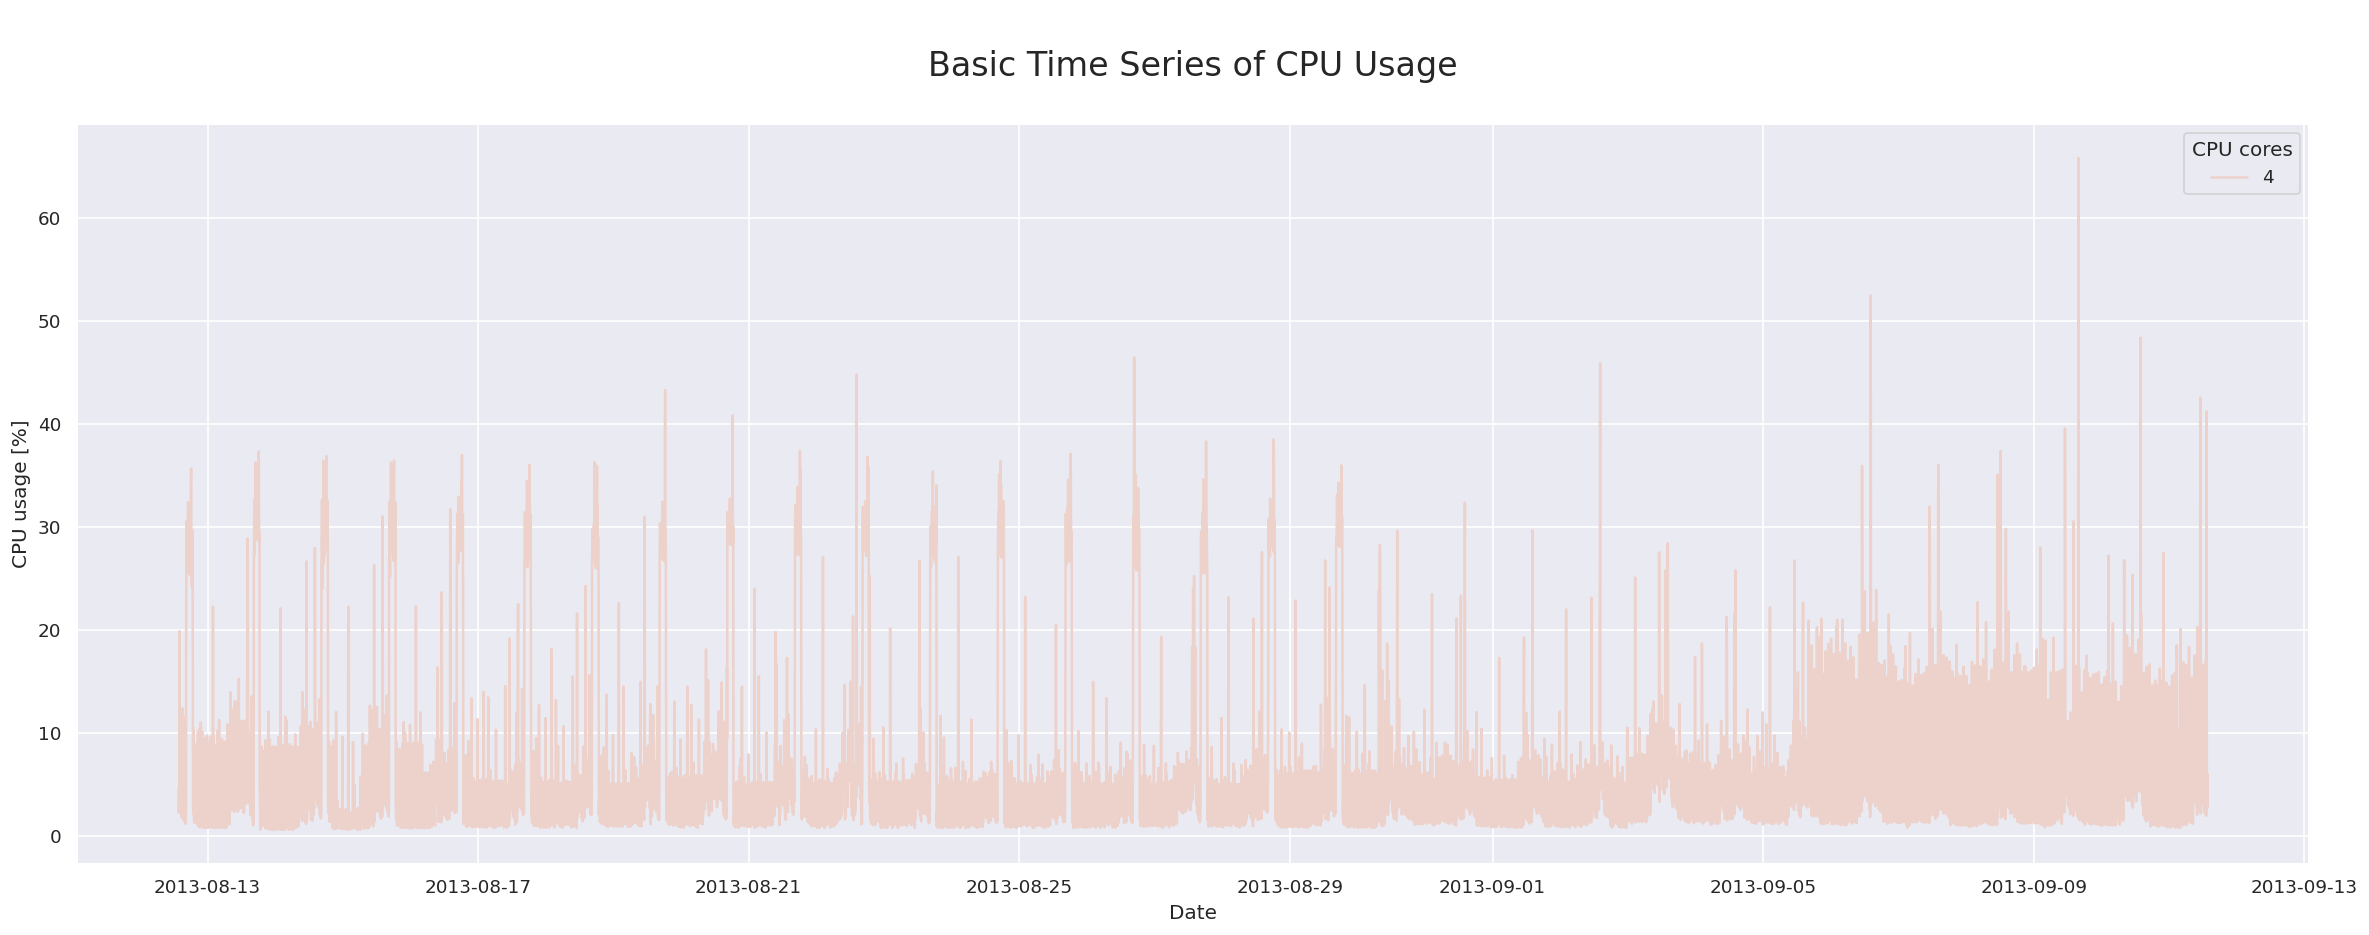

In [ ]:
sns.set(rc={'figure.figsize':(24,8)})
ax=sns.lineplot(data=df,x=df['Date'],y=df['CPU usage [%]'],hue=df['CPU cores'])
ax.axes.set_title("\nBasic Time Series of CPU Usage\n",fontsize=20);

df
min   2013-08-12 13:40:46
max   2013-09-11 13:39:58
Name: Date, dtype: datetime64[ns]




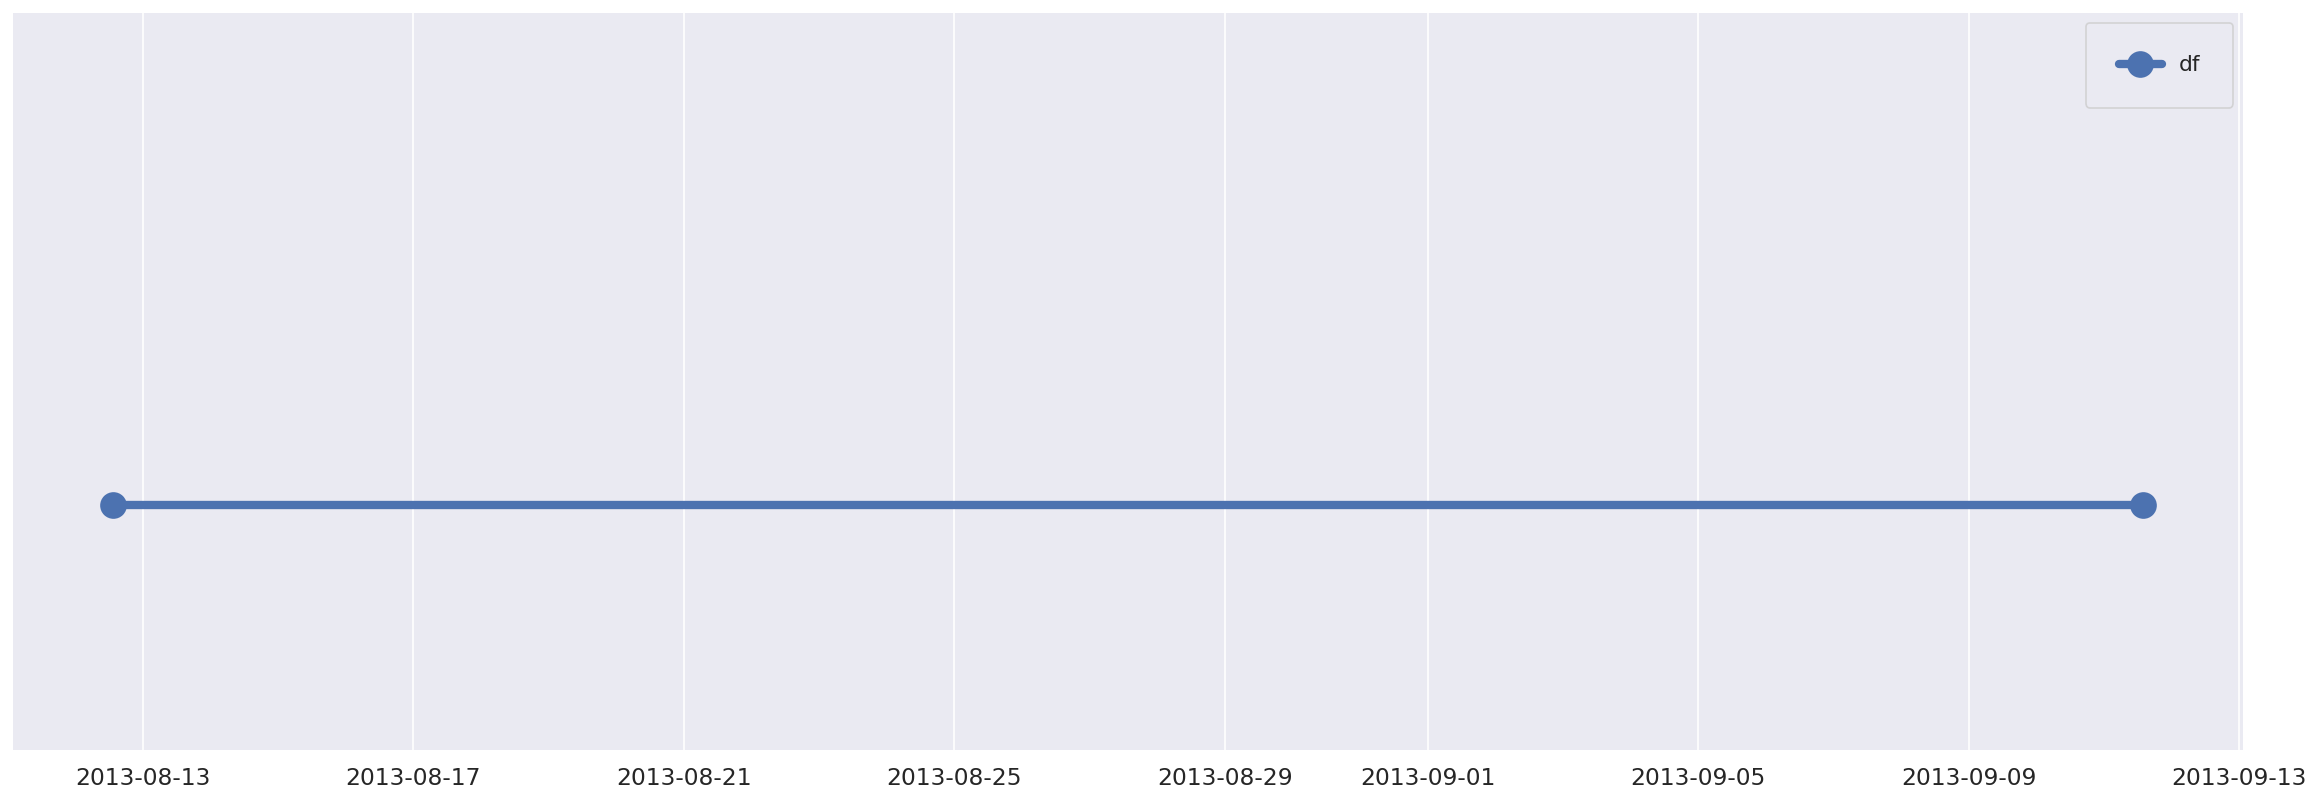

In [ ]:
train_range = df.Date.agg(['min', 'max'])

fig, ax = plt.subplots()
ax.plot(train_range, [0.2, 0.2], linewidth=5, marker='.', markersize=30, label='df')
#ax.plot(test_range, [0.3, 0.3], linewidth=5, marker='.', markersize=30, label='test', color=colors[1])
ax.set_ylim(0.1, 0.4)
ax.legend()
ax.set_yticks(ticks=[]);
plt.xticks(fontsize=14)
ax.legend(borderpad=1.5, fontsize=13)

print('df', train_range, '\n', sep='\n')

<Axes: xlabel='CPU usage [%]', ylabel='Count'>

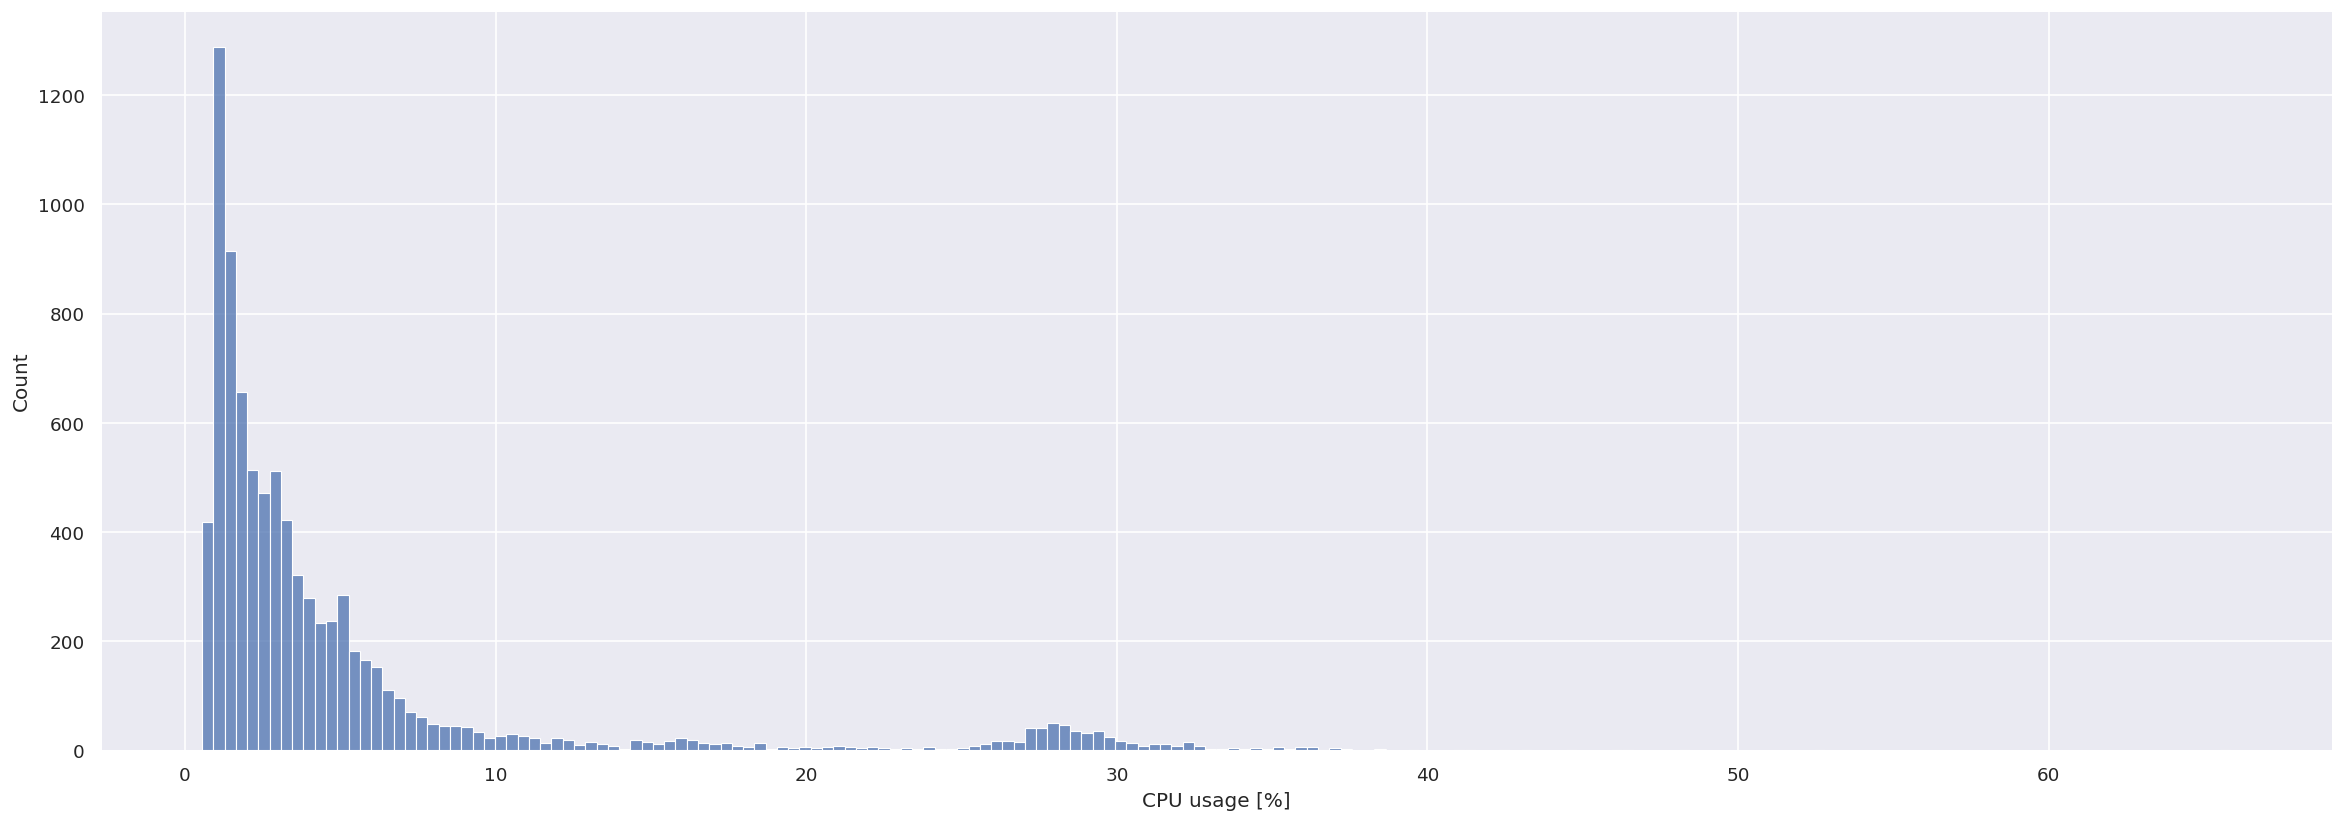

In [ ]:
sns.histplot(df['CPU usage [%]'])

In [ ]:
def process_time(df):
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['week'] = df['Date'].dt.isocalendar().week
    df.loc[df['week'] > 52, 'week'] = 52
    df['day'] = df['Date'].dt.day
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['dayofyear'] = df['Date'].dt.dayofyear

process_time(df)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8640 entries, 0 to 8639
Data columns (total 19 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   Timestamp [ms]                         8640 non-null   int64         
 1   CPU cores                              8640 non-null   int64         
 2   CPU capacity provisioned [MHZ]         8640 non-null   float64       
 3   CPU usage [MHZ]                        8640 non-null   float64       
 4   CPU usage [%]                          8640 non-null   float64       
 5   Memory capacity provisioned [KB]       8640 non-null   float64       
 6   Memory usage [KB]                      8640 non-null   float64       
 7   Disk read throughput [KB/s]            8640 non-null   float64       
 8   Disk write throughput [KB/s]           8640 non-null   float64       
 9   Network received throughput [KB/s]     8640 non-null   float64 

<Axes: xlabel='day', ylabel='CPU usage [%]'>

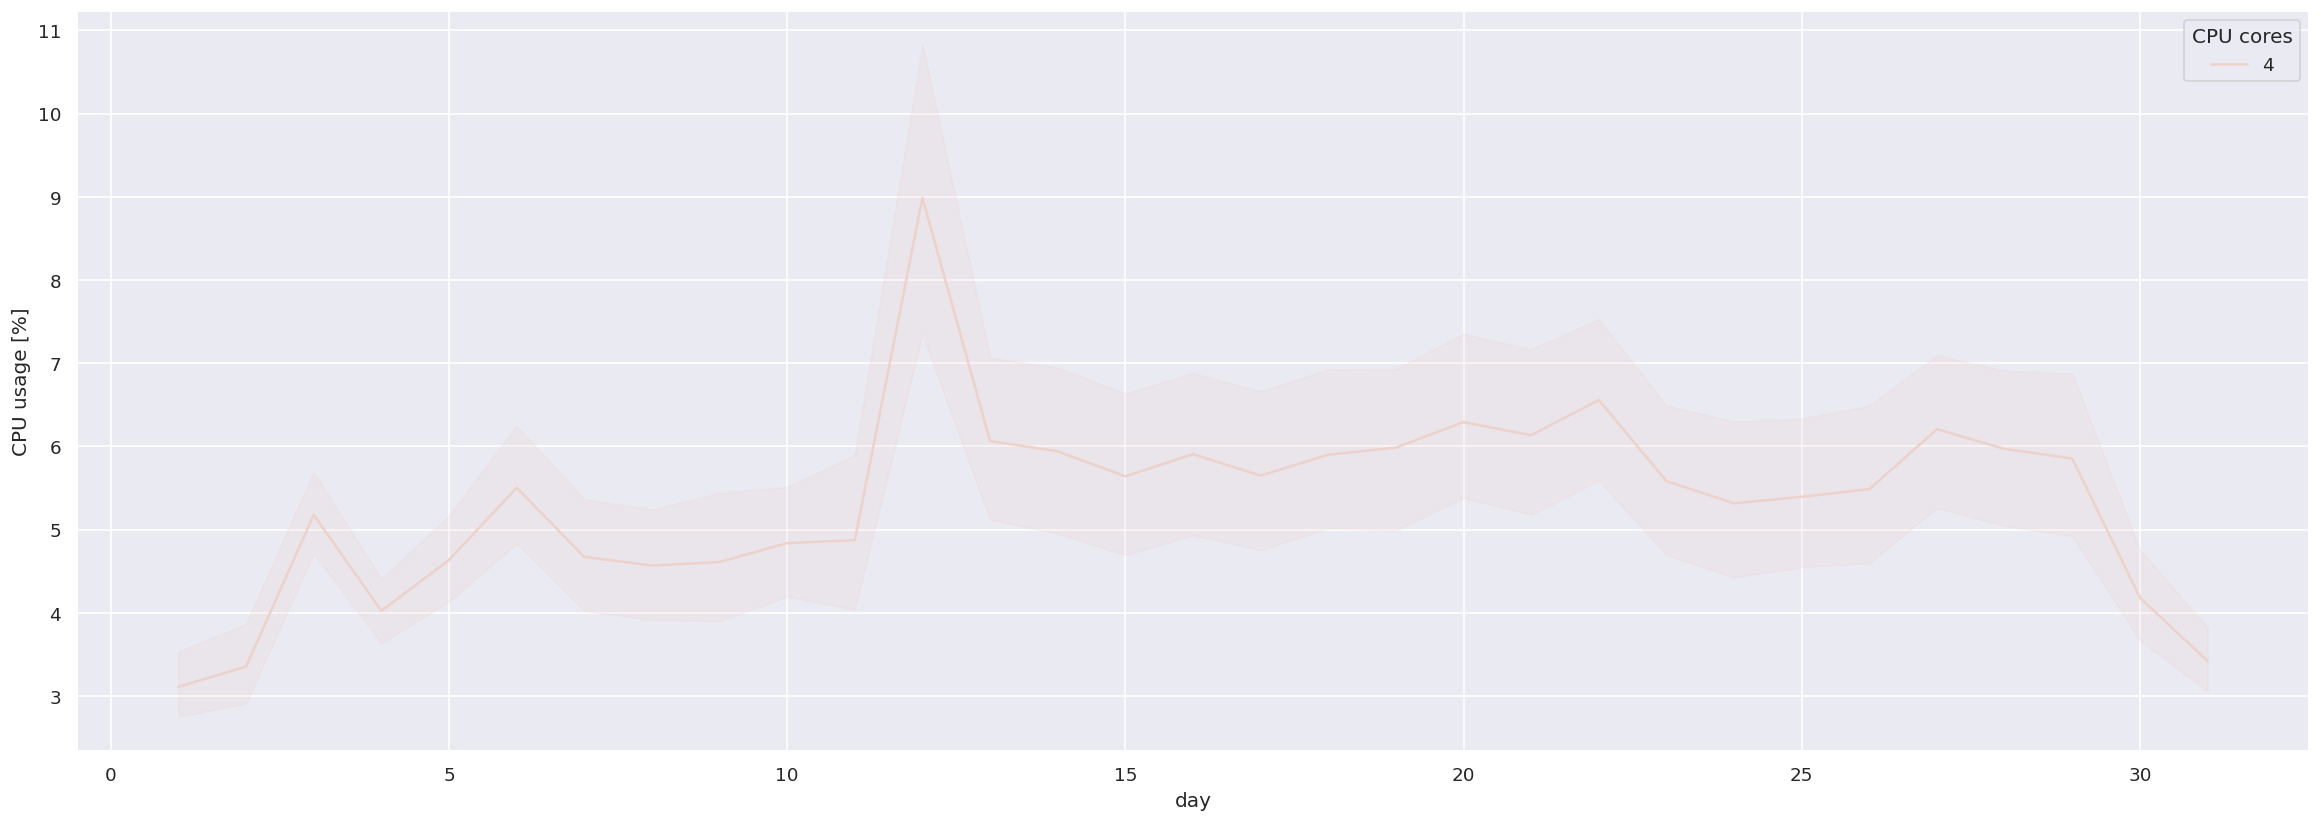

In [ ]:
sns.lineplot(x=df['day'],y=df['CPU usage [%]'],hue=df['CPU cores'])

<Axes: xlabel='month', ylabel='CPU usage [%]'>

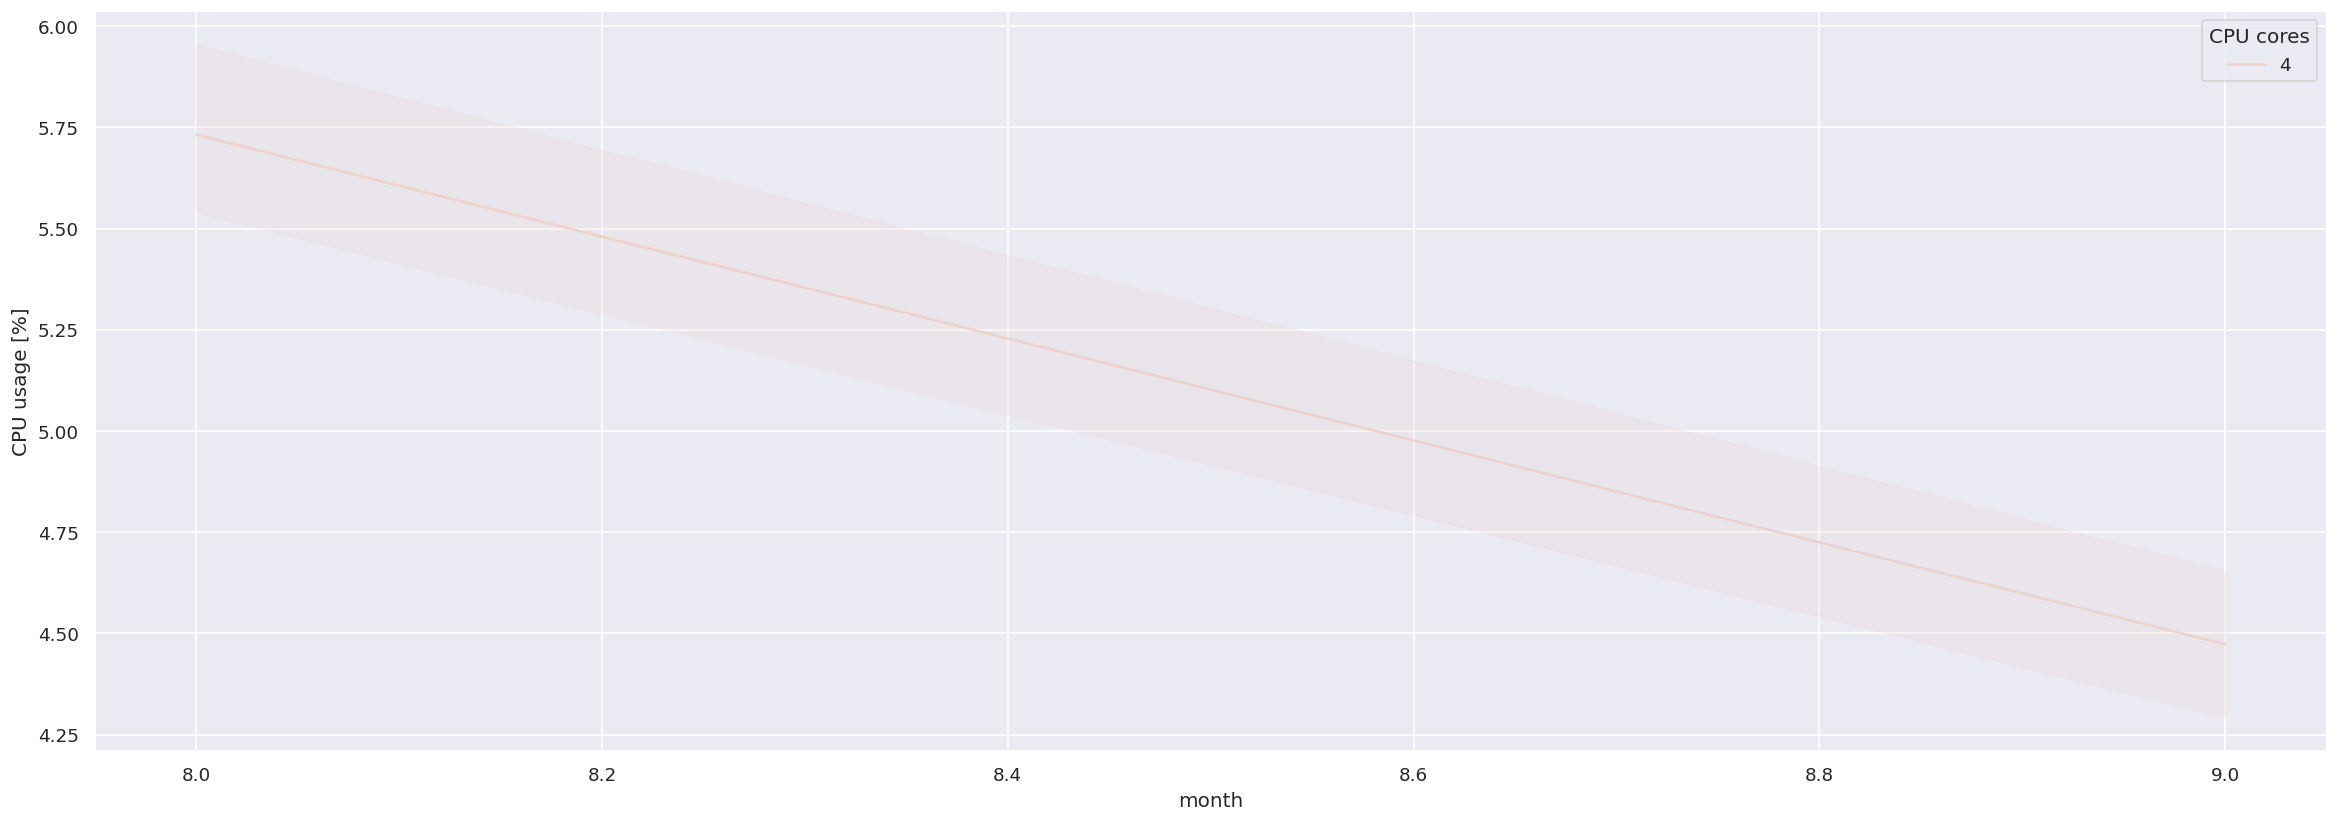

In [ ]:
sns.lineplot(x=df['month'],y=df['CPU usage [%]'],hue=df['CPU cores'])

<Axes: xlabel='dayofweek', ylabel='CPU usage [%]'>

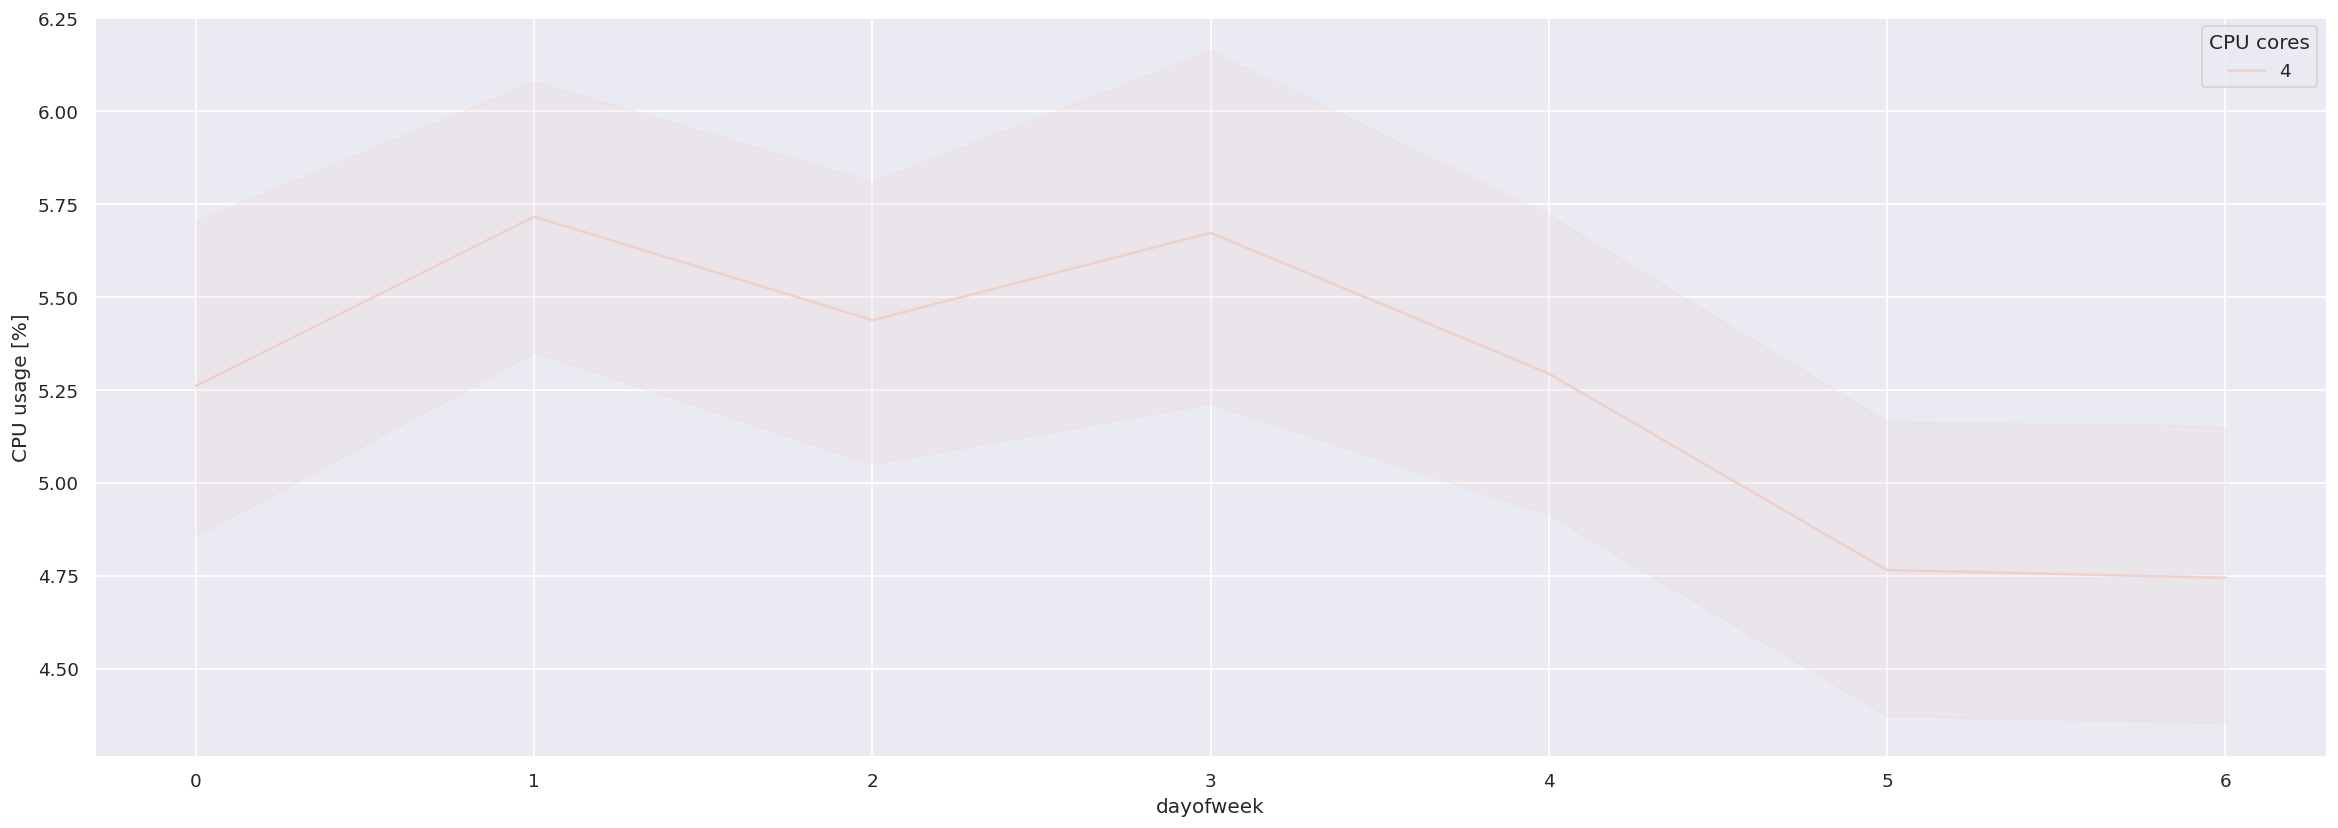

In [ ]:
sns.lineplot(x=df['dayofweek'],y=df['CPU usage [%]'],hue=df['CPU cores'])

<Axes: xlabel='dayofyear', ylabel='CPU usage [%]'>

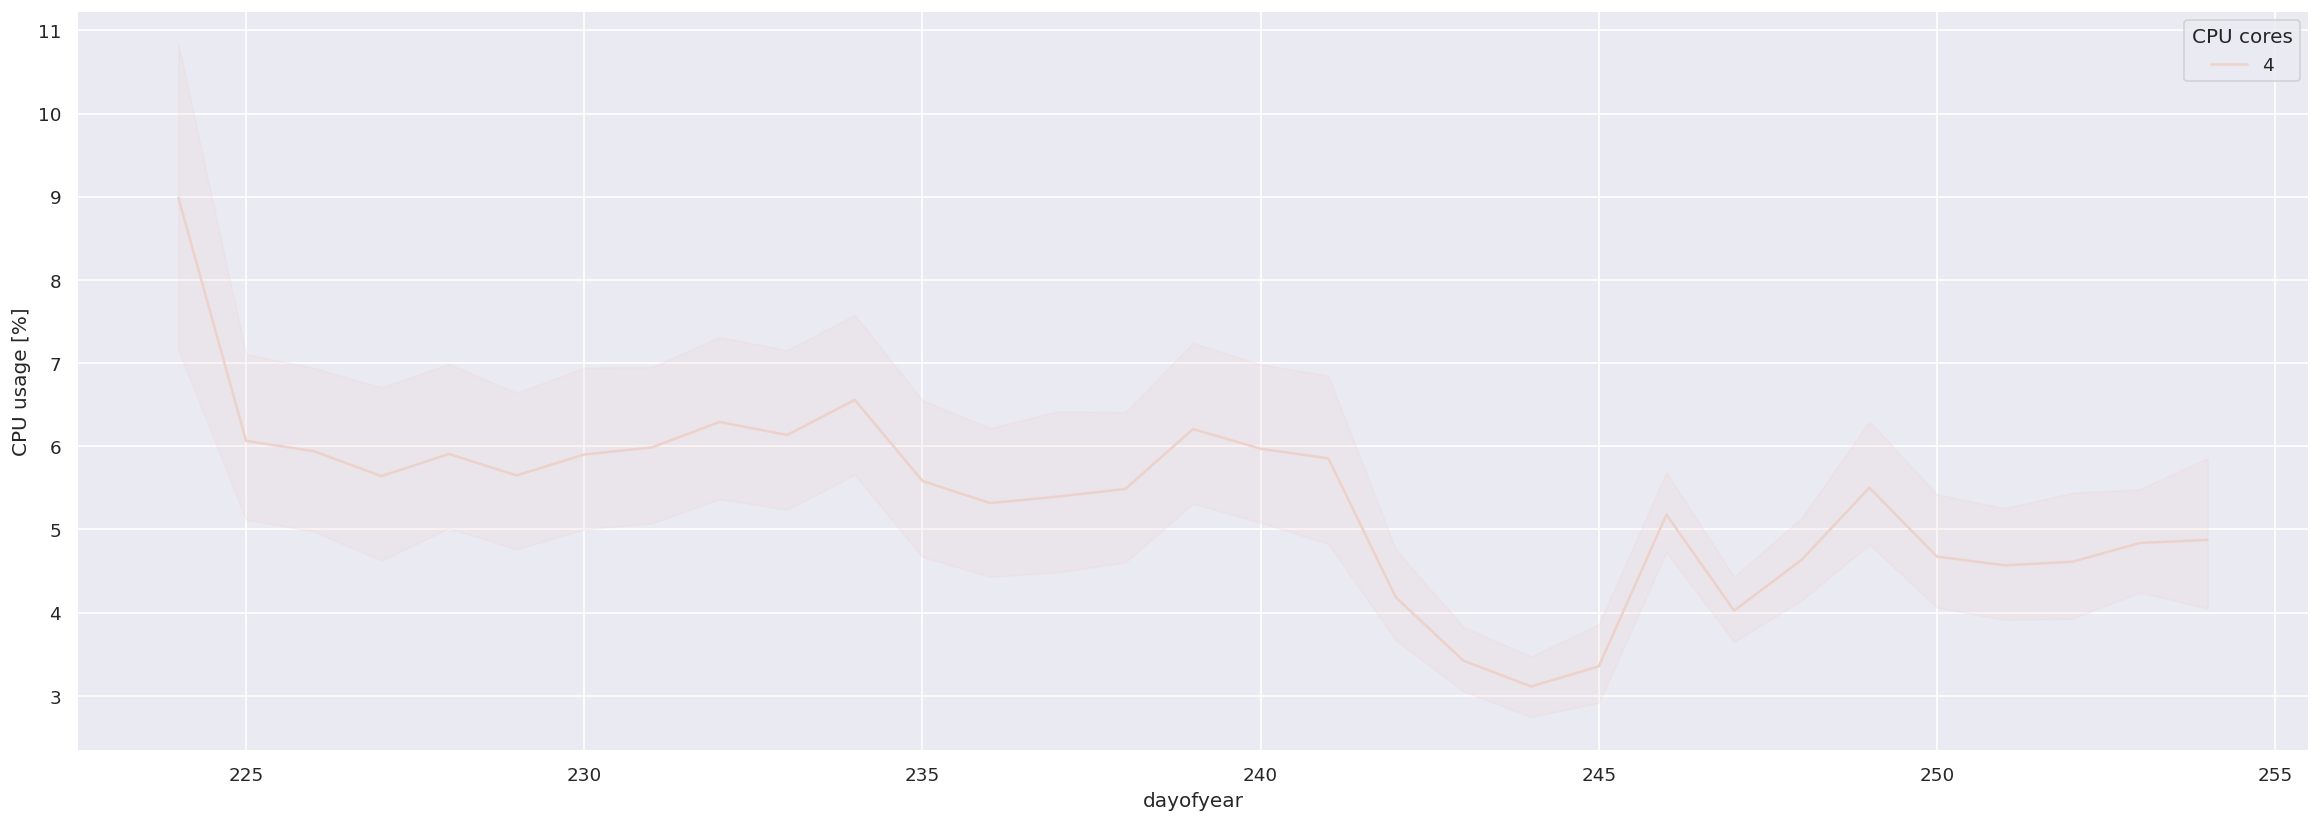

In [ ]:
sns.lineplot(x=df['dayofyear'],y=df['CPU usage [%]'],hue=df['CPU cores'])

In [ ]:
# Dickey Fuller Test Function
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    from statsmodels.tsa.stattools import adfuller
    print('Results of Dickey-Fuller Test:')
    print ("==============================================")

    dftest = adfuller(timeseries, autolag='AIC')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#lags Used', 'Number of Observations Used'])

    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print(dfoutput)

In [ ]:
# Stationarity Check - Lets do a quick check on Stationarity with Dickey Fuller Test
# Convert the DF to series first
ts = df['CPU usage [%]']
test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                -1.166906e+01
p-value                        1.853723e-21
#lags Used                     3.700000e+01
Number of Observations Used    8.602000e+03
Critical Value (1%)           -3.431110e+00
Critical Value (5%)           -2.861876e+00
Critical Value (10%)          -2.566949e+00
dtype: float64


In [ ]:
from statsmodels.tsa.stattools import adfuller
print('p-value : {}'.format(adfuller(df['CPU usage [%]'])))

p-value : (-11.66905576461128, 1.853722744196009e-21, 37, 8602, {'1%': -3.4311104339084104, '5%': -2.861876060538507, '10%': -2.5669488800920677}, 47887.66663237919)


<Axes: ylabel='CPU usage [%]'>

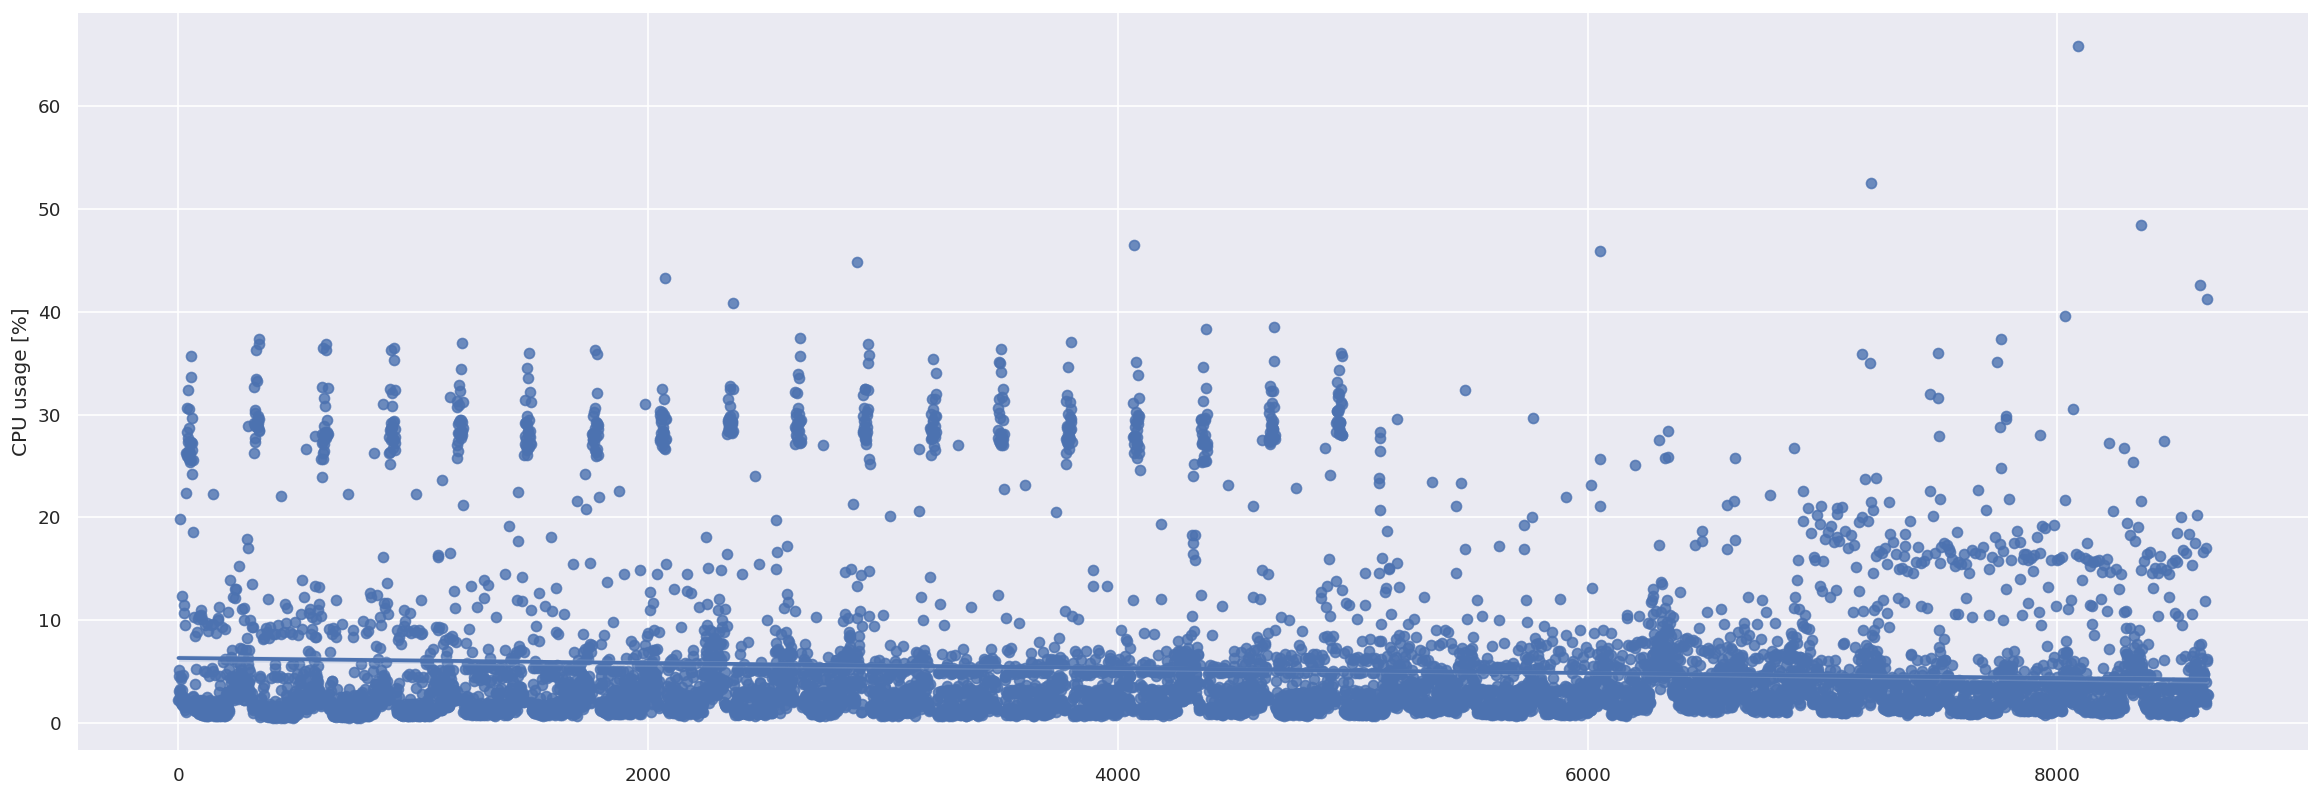

In [ ]:
# TrendLine
sns.regplot(x = df.index.values, y = df['CPU usage [%]'])

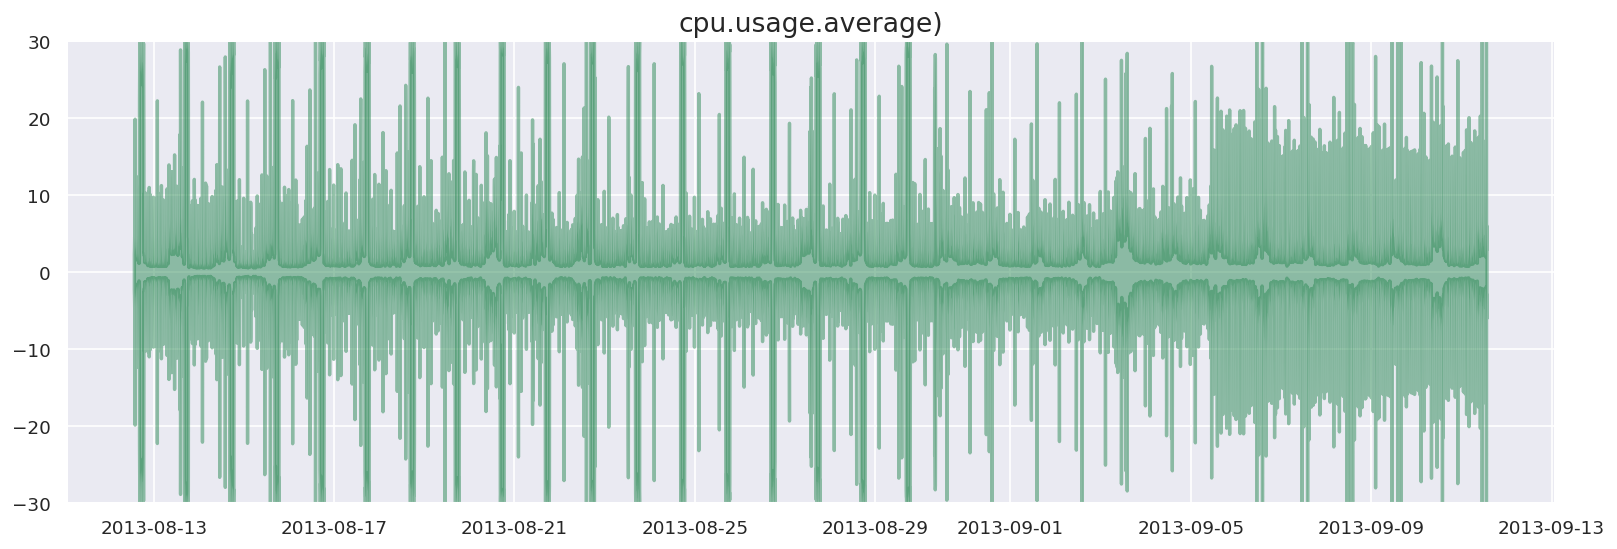

In [ ]:
x = df['Date']
y1 = df['CPU usage [%]'].values

# Plot
fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
plt.ylim(-30, 30)
plt.title('cpu.usage.average)', fontsize=16)
#plt.hlines(y=0, xmin=np.min(df.index.values, xmax=df.index.max(), linewidth=.5))
plt.show()

In [ ]:
X = df['Date']
Y = df['CPU usage [%]']
corr, _ = kendalltau(X, Y)
print('Kendall Rank correlation: %.5f' % corr)

Kendall Rank correlation: 0.03285


In [ ]:
def concordant_discordant(data):
    n = len(data)
    concordant = 0
    discordant = 0
    for i in range(n):
        for j in range(i+1, n):
            if data.iloc[i]['y'] > data.iloc[j]['y']:
                if data.index[i] > data.index[j]:
                    concordant += 1
                else:
                    discordant += 1
    return concordant, discordant


data = df['CPU usage [%]']
data = pd.DataFrame(data,index=pd.date_range(start='2023-01-09 07:30:00+00:00', end='2023-01-10 06:25:00+00:00'))

concordant, discordant = concordant_discordant(data)
print("Concordant pairs:", concordant)
print("Discordant pairs:", discordant)

# Test result - (-7)
# NO trend

Concordant pairs: 0
Discordant pairs: 0


1. If T=0 or the number of concordant and discordant pairs are equal, no trend exists.
2. If T=1 or T=-1, a strong trend exists.

[]

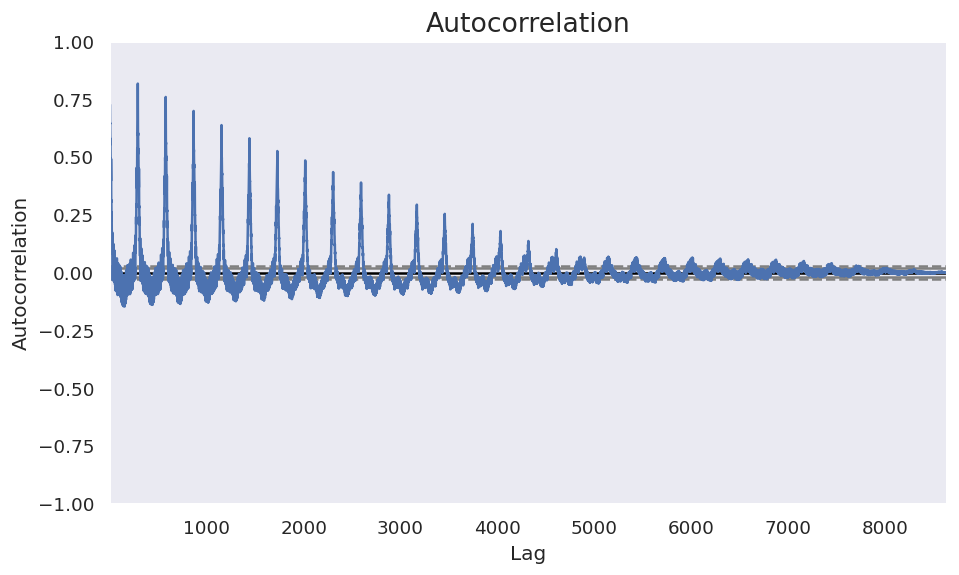

In [ ]:
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(df['CPU usage [%]'].tolist())
plt.title('Autocorrelation', fontsize=16)
plt.plot()

# Model Building - CPU usage Forecasting

In [ ]:
#importing dataset
dataset = pd.read_csv('/content/sample_vm_data.csv', sep=';\t')
df = pd.DataFrame(dataset)
print('Data Shape:', df.shape)
df.head()

Data Shape: (8640, 11)


<ipython-input-103-dd8c8a832cbc>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dataset = pd.read_csv('/content/sample_vm_data.csv', sep=';\t')


,Timestamp [ms],CPU cores,CPU capacity provisioned [MHZ],CPU usage [MHZ],CPU usage [%],Memory capacity provisioned [KB],Memory usage [KB],Disk read throughput [KB/s],Disk write throughput [KB/s],Network received throughput [KB/s],Network transmitted throughput [KB/s]
0,1376314846,4,9599.998916,219.199975,2.283333,6160384.0,1.145043e+06,0.000000,135.466667,3.400000,3.000000
1,1376315146,4,9599.998916,297.599966,3.100000,6160384.0,1.006631e+06,0.000000,152.333333,4.933333,4.733333
2,1376315446,4,9599.998916,436.799951,4.550000,6160384.0,1.480588e+06,0.266667,1165.666667,4.266667,3.666667
3,1376315746,4,9599.998916,214.399976,2.233333,6160384.0,9.730757e+05,0.000000,76.133333,2.066667,2.533333
4,1376316046,4,9599.998916,497.599944,5.183333,6160384.0,1.040186e+06,0.066667,106.666667,2.000000,2.000000


In [ ]:
Time_stamp = df["Timestamp [ms]"].tolist()
type(Time_stamp)
Date_time_linst = []
for i in Time_stamp:
  my_datetime = datetime.datetime.fromtimestamp(i)  # Apply fromtimestamp function
  Date_time_linst.append(my_datetime)

df["Date_time"] = pd.DataFrame(Date_time_linst)

In [ ]:
df_cpu = pd.DataFrame()
df_cpu['y'] = df['CPU usage [%]']
df_cpu['ds'] = df['Date_time']
df_cpu.head()

,y,ds
0,2.283333,2013-08-12 13:40:46
1,3.100000,2013-08-12 13:45:46
2,4.550000,2013-08-12 13:50:46
3,2.233333,2013-08-12 13:55:46
4,5.183333,2013-08-12 14:00:46


In [ ]:
df_cpu = df_cpu.set_index('ds').resample('H').quantile(q=0.7)

In [ ]:
df_cpu.shape

(721, 1)

In [ ]:
df_cpu.reset_index(inplace = True)

In [ ]:
df_cpu.shape

(721, 2)

In [ ]:
train = df_cpu[:650]
test = df_cpu[650:]
print(train.shape)
print(test.shape)

(650, 2)
(71, 2)


In [ ]:
m = Prophet(seasonality_mode='multiplicative',daily_seasonality=True)
m.fit(train)
future = m.make_future_dataframe(len(test), freq='1H')
forecast = m.predict(future)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsu4nbv6o/alhhcdlv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsu4nbv6o/kxwxadm4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58323', 'data', 'file=/tmp/tmpsu4nbv6o/alhhcdlv.json', 'init=/tmp/tmpsu4nbv6o/kxwxadm4.json', 'output', 'file=/tmp/tmpsu4nbv6o/prophet_model2m4guj1q/prophet_model-20231016103513.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:35:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:35:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
716,2013-09-11 09:00:00,1.408257,-4.111907,5.753993,1.207229,1.624243,-0.355343,-0.355343,-0.355343,-0.330694,-0.330694,-0.330694,0.024649,0.024649,0.024649,0.0,0.0,0.0,0.942555
717,2013-09-11 10:00:00,1.402265,-3.641037,6.414237,1.193758,1.622617,-0.024620,-0.024620,-0.024620,-0.004592,-0.004592,-0.004592,0.020029,0.020029,0.020029,0.0,0.0,0.0,1.395826
718,2013-09-11 11:00:00,1.396272,-3.382572,6.743941,1.180915,1.621581,-0.028289,-0.028289,-0.028289,-0.012475,-0.012475,-0.012475,0.015815,0.015815,0.015815,0.0,0.0,0.0,1.378854
719,2013-09-11 12:00:00,1.390280,-4.366402,5.584561,1.170372,1.620205,-0.385457,-0.385457,-0.385457,-0.373397,-0.373397,-0.373397,0.012060,0.012060,0.012060,0.0,0.0,0.0,0.871153
720,2013-09-11 13:00:00,1.384287,-4.265649,5.333917,1.159839,1.618896,-0.626215,-0.626215,-0.626215,-0.617403,-0.617403,-0.617403,0.008812,0.008812,0.008812,0.0,0.0,0.0,0.529624


In [ ]:
def error_metrics(y_fcast, y_test):
    """
    Return mean absolute percentage error (MAPE)
           mean percentage error (MPE)
           mean absolute error (MAE)
           root mean square error (RMSE)

    """
    print(f'MAPE: {np.mean(np.abs((y_test - y_fcast)/y_test))*100}')
    print(f'MPE:  {np.mean((y_test - y_fcast)/y_test)*100}')
    print(f'MAE:  {np.mean(np.abs(y_test - y_fcast))}')
    print(f'RMSE: {np.sqrt(np.mean((y_test - y_fcast)**2))}')


In [ ]:
error_metrics(y_fcast = forecast[-len(test):]['yhat'].values,
              y_test = test['y'].values)

MAPE: 71.2957989781145
MPE:  56.10195138648578
MAE:  2.8547583221745447
RMSE: 3.18620557866231


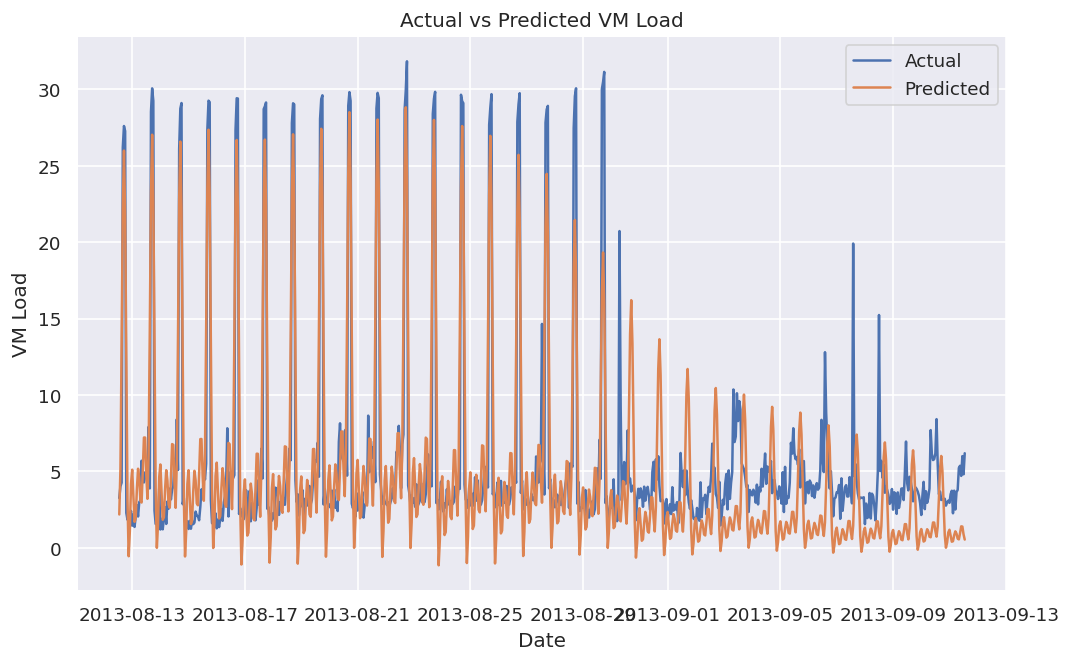

In [ ]:
# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(df_cpu['ds'], df_cpu['y'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('VM Load')
plt.title('Actual vs Predicted VM Load')
plt.show()

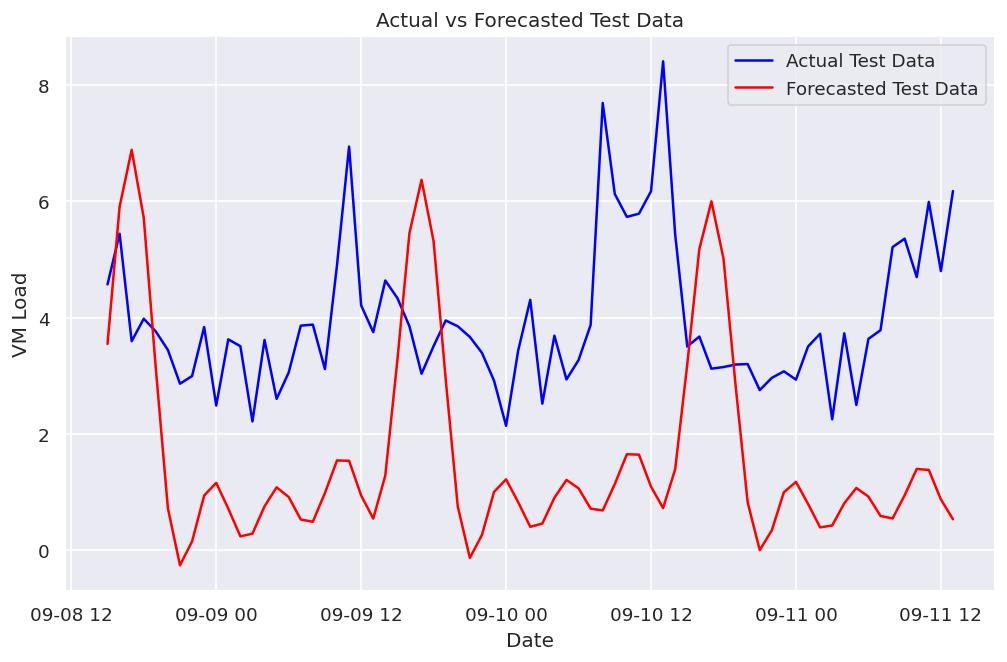

In [ ]:
# Plot the actual test data and forecasted values for the test data
plt.figure(figsize=(10, 6))
plt.plot(test['ds'], test['y'], label='Actual Test Data', color='blue')
plt.plot(test['ds'], forecast['yhat'][-len(test):], label='Forecasted Test Data', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('VM Load')
plt.title('Actual vs Forecasted Test Data')
plt.show()


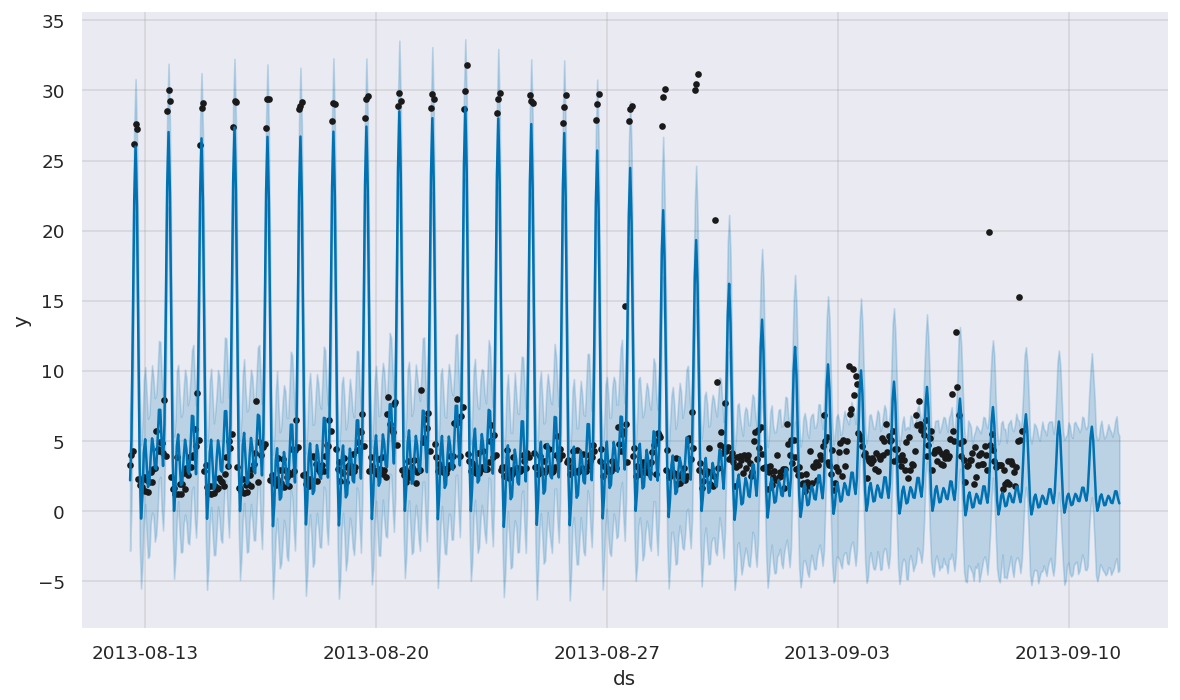

In [ ]:
plot1 = m.plot(forecast)


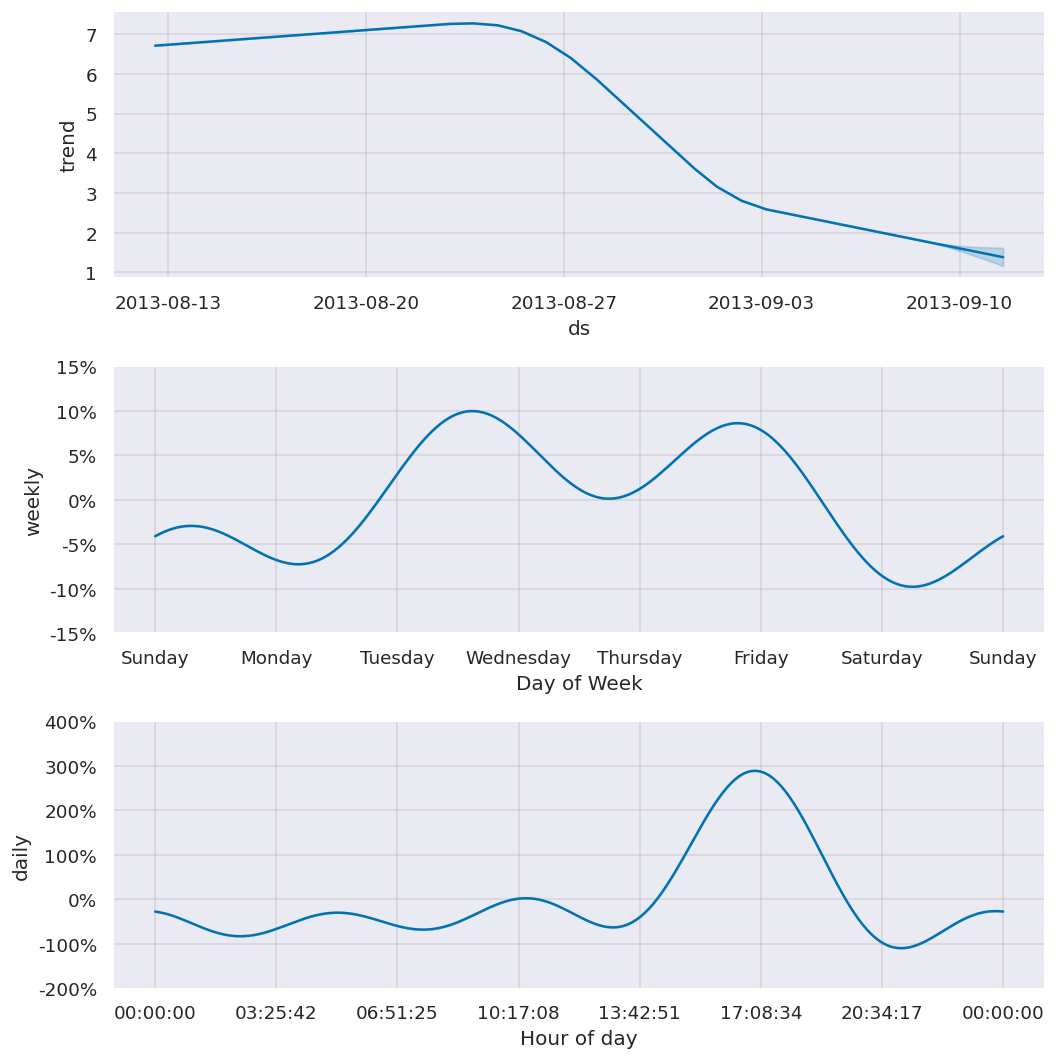

In [ ]:
plt2 = m.plot_components(forecast)

# Model Building - Memory usage Forecasting

In [ ]:
df_mem = pd.DataFrame()
df_mem['y'] = df['Memory usage [KB]']
df_mem['ds'] = df['Date_time']
df_mem.head()

,y,ds
0,1.145043e+06,2013-08-12 13:40:46
1,1.006631e+06,2013-08-12 13:45:46
2,1.480588e+06,2013-08-12 13:50:46
3,9.730757e+05,2013-08-12 13:55:46
4,1.040186e+06,2013-08-12 14:00:46


In [ ]:
df_mem = df_mem.set_index('ds').resample('H').quantile(q=0.7)

In [ ]:
df_mem.reset_index(inplace = True)

In [ ]:
df_mem.shape

(721, 2)

In [ ]:
train = df_mem[:650]
test = df_mem[650:]
print(train.shape)
print(test.shape)

(650, 2)
(71, 2)


In [ ]:
m = Prophet(daily_seasonality=True)
m.fit(train)
future = m.make_future_dataframe(len(test), freq='1H')
forecast = m.predict(future)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsu4nbv6o/qap4b8bw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsu4nbv6o/bzchbn_y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12475', 'data', 'file=/tmp/tmpsu4nbv6o/qap4b8bw.json', 'init=/tmp/tmpsu4nbv6o/bzchbn_y.json', 'output', 'file=/tmp/tmpsu4nbv6o/prophet_modelf_2cm0li/prophet_model-20231016103517.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:35:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:35:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
716,2013-09-11 09:00:00,1.525673e+06,1.164373e+06,2.143655e+06,1.519677e+06,1.532139e+06,140114.088475,140114.088475,140114.088475,196043.281620,196043.281620,196043.281620,-55929.193145,-55929.193145,-55929.193145,0.0,0.0,0.0,1.665788e+06
717,2013-09-11 10:00:00,1.526092e+06,1.268594e+06,2.231828e+06,1.519921e+06,1.532794e+06,244881.660688,244881.660688,244881.660688,303004.922045,303004.922045,303004.922045,-58123.261357,-58123.261357,-58123.261357,0.0,0.0,0.0,1.770974e+06
718,2013-09-11 11:00:00,1.526511e+06,1.294084e+06,2.276898e+06,1.520157e+06,1.533356e+06,240131.044013,240131.044013,240131.044013,299573.121874,299573.121874,299573.121874,-59442.077862,-59442.077862,-59442.077862,0.0,0.0,0.0,1.766642e+06
719,2013-09-11 12:00:00,1.526929e+06,1.230560e+06,2.243305e+06,1.520374e+06,1.533969e+06,197808.075984,197808.075984,197808.075984,257651.528648,257651.528648,257651.528648,-59843.452664,-59843.452664,-59843.452664,0.0,0.0,0.0,1.724737e+06
720,2013-09-11 13:00:00,1.527348e+06,1.189228e+06,2.212386e+06,1.520562e+06,1.534587e+06,198342.217267,198342.217267,198342.217267,257637.440542,257637.440542,257637.440542,-59295.223274,-59295.223274,-59295.223274,0.0,0.0,0.0,1.725690e+06


In [ ]:
def error_metrics(y_fcast, y_test):
    """
    Return mean absolute percentage error (MAPE)
           mean percentage error (MPE)
           mean absolute error (MAE)
           root mean square error (RMSE)

    """
    print(f'MAPE: {np.mean(np.abs((y_test - y_fcast)/y_test))*100}')
    print(f'MPE:  {np.mean((y_test - y_fcast)/y_test)*100}')
    print(f'MAE:  {np.mean(np.abs(y_test - y_fcast))*100}')
    print(f'RMSE: {np.sqrt(np.mean((y_test - y_fcast)**2))}')


In [ ]:
error_metrics(y_fcast = forecast[-len(test):]['yhat'].values,
              y_test = test['y'].values)

MAPE: 15.27004680885511
MPE:  8.787937381364761
MAE:  25195033.082303524
RMSE: 312872.5622962641


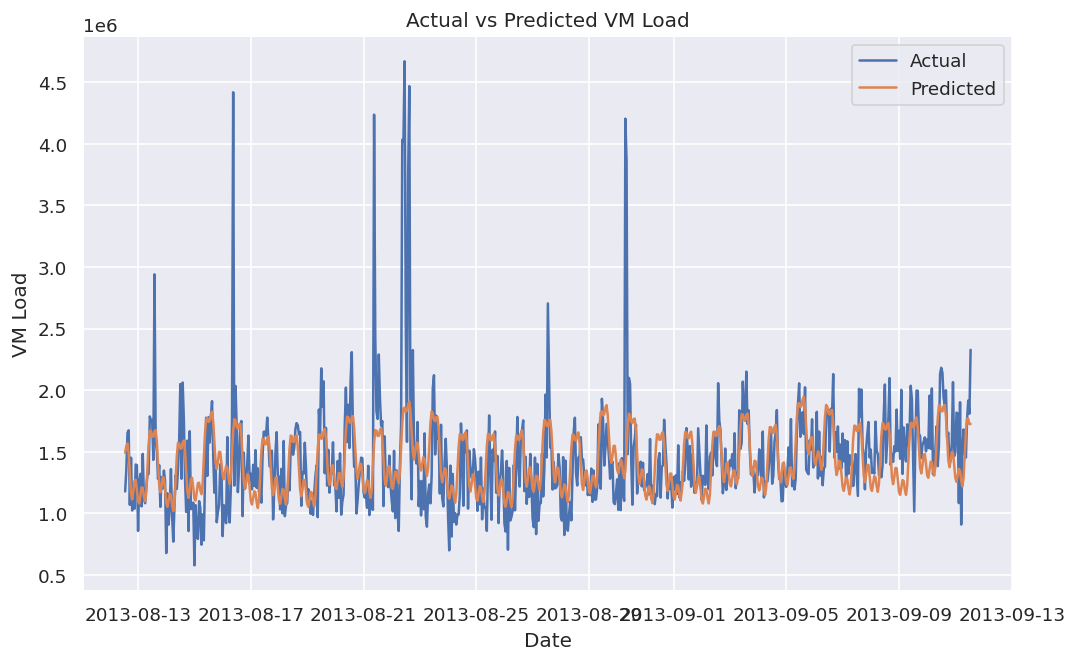

In [ ]:
# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(df_mem['ds'], df_mem['y'], label='Actual')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('VM Load')
plt.title('Actual vs Predicted VM Load')
plt.show()

In [ ]:
df_mem.head()

,ds,y
0,2013-08-12 13:00:00,1.178597e+06
1,2013-08-12 14:00:00,1.356017e+06
2,2013-08-12 15:00:00,1.653392e+06
3,2013-08-12 16:00:00,1.673945e+06
4,2013-08-12 17:00:00,1.069965e+06


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsu4nbv6o/ofw95y10.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsu4nbv6o/xdhd5dfd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21222', 'data', 'file=/tmp/tmpsu4nbv6o/ofw95y10.json', 'init=/tmp/tmpsu4nbv6o/xdhd5dfd.json', 'output', 'file=/tmp/tmpsu4nbv6o/prophet_modeluz3_m5vc/prophet_model-20231016103518.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:35:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:35:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 233684.38925545267


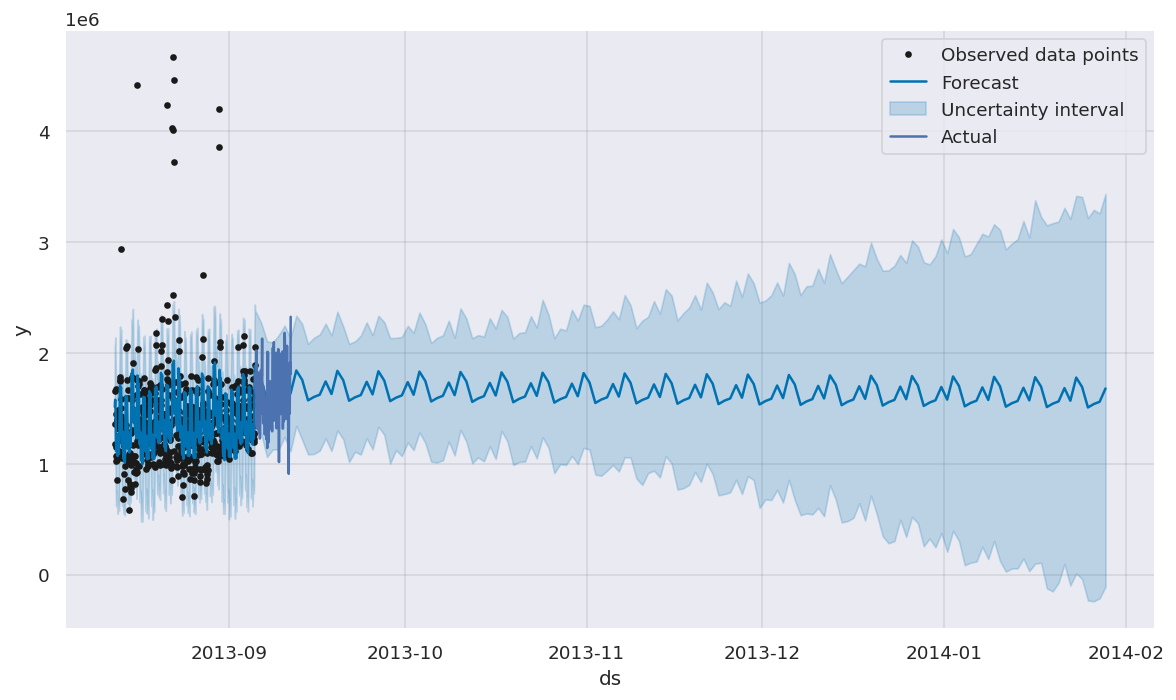

In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

df = df_mem

# Split data into training and testing sets
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

# Build and fit the model
m = Prophet()
m.fit(train_df)

# Make predictions for the testing set
future = m.make_future_dataframe(periods=len(test_df))
forecast = m.predict(future)

# Evaluate the model using MAE
mae = mean_absolute_error(test_df['y'], forecast['yhat'][-len(test_df):])
print('MAE:', mae)

# Plot actual and predicted values
fig = m.plot(forecast)
plt.plot(test_df['ds'], test_df['y'], label='Actual')
plt.legend()
plt.show()


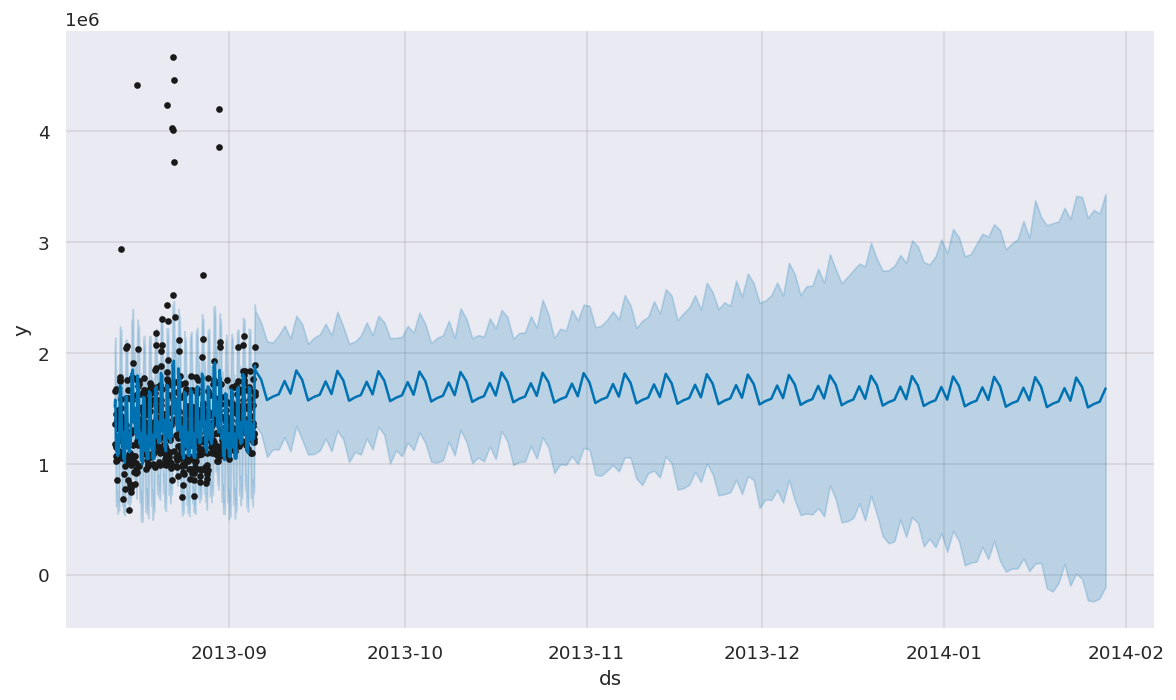

In [ ]:
plot2 = m.plot(forecast)


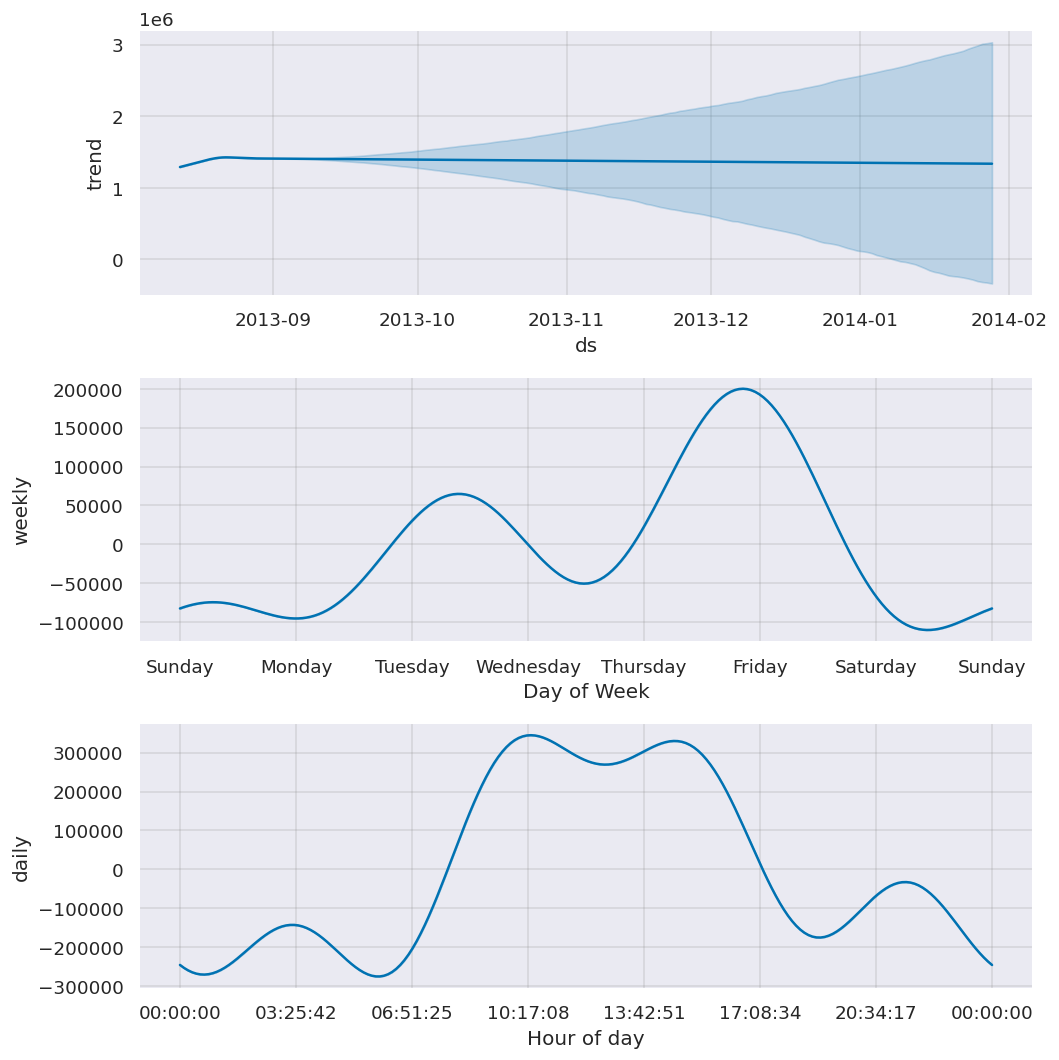

In [ ]:
plot3 = m.plot_components(forecast)